In [20]:
import os
import csv
import pyabc
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from anasazi_cpp.anasazi_model import anasazi_model

In [21]:
target_data = []
with open("../data/target_data.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        target_data.append(int(row[1]))

observed_data = {"population": target_data}

In [22]:
def model(parameters):
    # print("calling model")
    # print(type(parameters))
    # print(parameters['max_storage'])
    int_params = []
    double_params = []
    
    int_params.append(parameters.max_store_year)
    int_params.append(parameters.max_storage)
    int_params.append(parameters.household_need)
    int_params.append(parameters.min_fission)
    int_params.append(parameters.max_fission)
    int_params.append(parameters.min_death)
    int_params.append(parameters.max_death)
    int_params.append(parameters.max_distance)
    int_params.append(parameters.initial_min)
    int_params.append(parameters.initial_max)
    
#     print(int_params)
    
    double_params.append(parameters.annual_variance)
    double_params.append(parameters.spatial_variance)
    double_params.append(parameters.fertility_prop)
    double_params.append(parameters.harvest_adj)
    double_params.append(parameters.new_household)
#     print(double_params)
    
#   convert returned numpy array to list
    ret  = anasazi_model(551, int_params, double_params).tolist()
    return {"population": ret}

In [23]:
def distance(x, y):
    error = np.array([a_i - b_i for a_i, b_i in zip(x["population"], y["population"])])
    rmse = np.sqrt(np.mean(error**2))
#     print("******************" + str(rmse))
    return rmse

In [24]:
parameter_priors = pyabc.Distribution(
    max_store_year = pyabc.RV("randint", 1, 3),
    max_storage = pyabc.RV("randint", 1400, 1600),
    household_need = pyabc.RV("randint", 700, 900),
    min_fission = pyabc.RV("randint", 16, 18),
    max_fission = pyabc.RV("randint", 25, 27),
    min_death = pyabc.RV("randint", 24, 27),
    max_death = pyabc.RV("randint", 35, 38),
    max_distance = pyabc.RV("randint", 900, 1100),
    initial_min = pyabc.RV("randint", 800, 1200),
    initial_max = pyabc.RV("randint", 1400, 1600),
    annual_variance = pyabc.RV("uniform", 0, 0.5),
    spatial_variance = pyabc.RV("uniform", 0, 0.5),
    fertility_prop = pyabc.RV("uniform", 0, 0.5),
    harvest_adj = pyabc.RV("uniform", 0, 0.5),
    new_household = pyabc.RV("uniform", 0, 0.5))    

In [25]:
abc = pyabc.ABCSMC(model, parameter_priors,distance)

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
history = abc.new(db_path, observed_data)

INFO:Sampler:Parallelizing the sampling on 16 cores.
INFO:History:Start <ABCSMC(id=42, start_time=2020-12-11 22:57:37.767308, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.2, max_nr_populations=3)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 113.93318798692454
INFO:ABC:t: 0, eps: 113.93318798692454.
INFO:ABC:Acceptance rate: 100 / 115 = 8.6957e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 113.93318798692454.


In [8]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0
t,
0,1.0


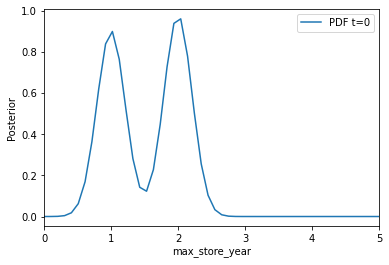

In [19]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=5,
        x="max_store_year", ax=ax,
        label="PDF t={}".format(t))
# ax.axvline(observed_data, color="k", linestyle="dashed");
ax.legend();

KeyError: 'annual_variance'

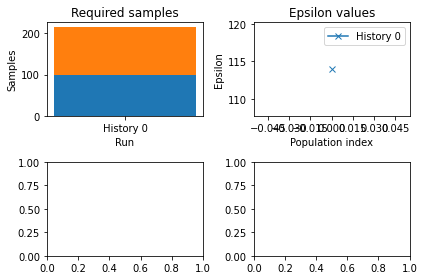

In [17]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
pyabc.visualization.plot_credible_intervals(
    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
    show_mean=True, show_kde_max_1d=True,
    refval={'max_store_year': 2.5}, arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()